Referenzfahrt gestartet.
44 mm
POS
Zeile 1 wird geschrieben:
HALLO           Zeile 2 wird geschrieben:
MME
Wird gestartet.
POS
HALLO




MME




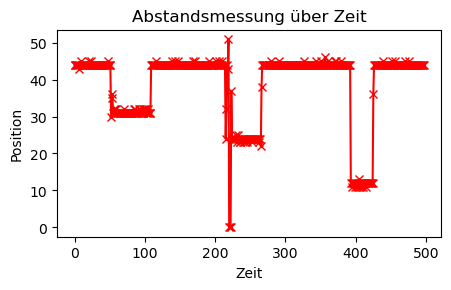

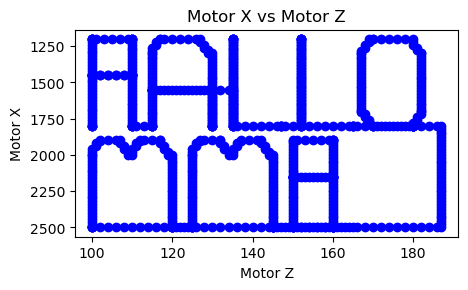

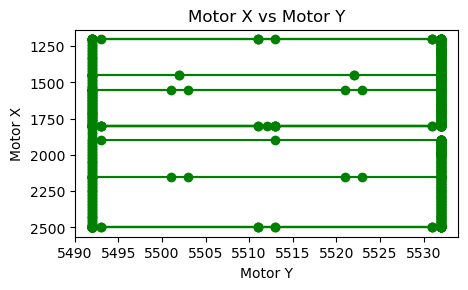

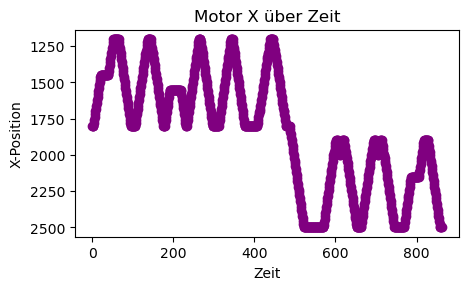

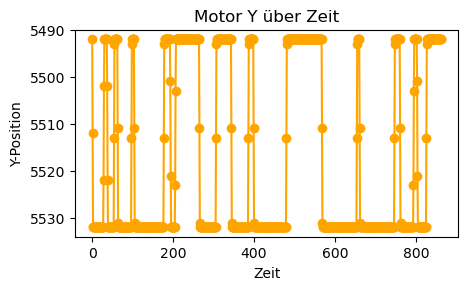

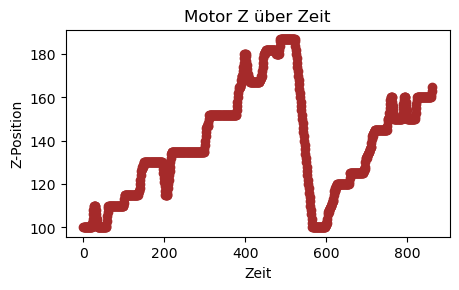

In [37]:
import tkinter as tk                                # Importiere tkinter-Modul und aliasiere als tk für GUI-Erstellung
import serial                                       # Importiere pySerial für serielle Kommunikation
import re                                           # Importiere reguläre Ausdrücke für Textanalyse
import threading                                    # Importiere threading für nebenläufige Threads
import queue                                        # Importiere queue für Thread-kommunikation
import matplotlib.pyplot as plt                     # Importiere pyplot für Diagramme
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg  # Importiere TkAgg-Canvas für Matplotlib in Tkinter

# UART-Verbindung erstellen
ser = serial.Serial(                                # Erstelle serielle Verbindung mit folgenden Parametern
    'COM7',                                         # Schnittstelle COM7
    baudrate=115200,                                # Datenrate 115200 Baud
    bytesize=serial.EIGHTBITS,                      # 8 Datenbits
    parity=serial.PARITY_EVEN,                      # gerade Parität
    stopbits=serial.STOPBITS_ONE,                   # ein Stoppbit
    timeout=0.1                                     # Lese-Timeout von 0.1 Sekunden
)                                                  # Ende der Serial-Konfiguration

# Datenstrukturen
time_values = []                                   # Liste für Zeitstempel der Abstandsmessung
position_values = []                               # Liste für gemessene Positionen (Abstände)
counter = 0                                        # Zähler für Abstandsmesspunkte

motor_x_history = []                               # Historie der X-Positionen des Motors
motor_y_history = []                               # Historie der Y-Positionen des Motors
motor_z_history = []                               # Historie der Z-Positionen des Motors
motor_time = []                                    # Gemeinsamer Zeitindex für alle Motorpositionen
motor_x_time = []                                  # Zeitstempel für X-Daten (derzeit ungenutzt)
motor_y_time = []                                  # Zeitstempel für Y-Daten (derzeit ungenutzt)
motor_z_time = []                                  # Zeitstempel für Z-Daten (derzeit ungenutzt)

motor_counter =  0                                 # Zähler für Motor-Datensätze

messung_aktiv = False                              # Flag, ob Abstandsmessung aktiv ist
pos_aktiv     = False                              # Flag, ob Positionsausgabe aktiv ist

# Queue für empfangene Zeilen
rx_queue = queue.Queue()                           # Initialisiere Thread-sichere Queue für empfangene Daten

# Thread für kontinuierliches Lesen
def reader_thread():                               # Funktion, die im Hintergrund permanent liest
    while True:                                    # Endlosschleife für kontinuierliches Einlesen
        try:
            raw = ser.readline()                   # Lese eine Zeile von der seriellen Schnittstelle
            if raw:                                # Prüfe, ob tatsächlich Daten empfangen wurden
                line = raw.decode("latin-1", errors="ignore").strip()  # Dekodiere und strippe Zeile
                rx_queue.put(line)                 # Schreibe die bereinigte Zeile in die Queue
        except serial.SerialException:             # Falls ein Serial-Fehler auftritt
            break                                  # Beende die Lese-Schleife
threading.Thread(target=reader_thread, daemon=True).start()  # Starte den Lese-Thread als Daemon

# GUI-Callbacks
def toggle_measurement(*args):                     # Callback, wenn Abstandsmessung ein-/ausgeschaltet wird
    global messung_aktiv                           # Erlaube Modifikation des globalen Flags
    if abstand_var.get():                          # Wenn Checkbox aktiviert
        ser.write(b"M\r\n")                        # Sende Startbefehl für Abstandsmessung
        messung_aktiv = True                       # Setze Flag auf True
    else:                                          # Wenn Checkbox deaktiviert
        ser.write(b"MN\r\n")                       # Sende Stopbefehl für Abstandsmessung
        messung_aktiv = False                      # Setze Flag auf False
        ser.reset_input_buffer()                   # Leere den Eingabepuffer

def send_text():                                   # Callback zum Senden von Textzeilen
    z1 = text_line1.get().strip()                  # Lese und trimme erste Eingabezeile
    z2 = text_line2.get().strip()                  # Lese und trimme zweite Eingabezeile
    if z1:                                         # Falls erste Zeile nicht leer
        ser.write(f"{z1}:Texto".encode())          # Sende formatierten Text
        ser.write(b"\r\n")                         # Sende Zeilenumbruch
    if z2:                                         # Falls zweite Zeile nicht leer
        ser.write(f"{z2}:Textu".encode())          # Sende formatierten Text
        ser.write(b"\r\n")                         # Sende Zeilenumbruch

def toggle_ref(*args):                             # Callback für Referenzfahrt-Checkbox
    if ref_var.get():                              # Wenn Checkbox aktiviert
        ser.write(b"R\r\n")                        # Sende Referenzfahrt-Befehl

def start_action():                                # Callback für Start-Button
    ser.write(b"START\r\n")                        # Sende START-Befehl

def stop_action():                                 # Callback für Not-Aus-Button
    ser.write(b"STOP\r\n")                         # Sende STOP-Befehl

def toggle_pos(*args):                             # Callback für Positions-Checkbox
    global pos_aktiv                               # Erlaube Modifikation des globalen Flags
    if pos_var.get():                              # Wenn Checkbox aktiviert
        ser.write(b"POS\r\n")                      # Sende Befehl für Positionsausgabe
        pos_aktiv = True                           # Setze Flag auf True
    else:                                          # Wenn Checkbox deaktiviert
        ser.write(b"NPOS\r\n")                     # Sende Befehl zum Stoppen der Positionsausgabe
        pos_aktiv = False                          # Setze Flag auf False
        ser.reset_input_buffer()                   # Leere den Eingabepuffer

# Plot-Update-Funktion
def update_plots():                                # Zeichnet alle Diagramme neu
    # Abstandsmessung
    ax.clear()                                     # Leere das Abstandslinien-Diagramm
    ax.plot(time_values, position_values, marker="x", linestyle="-", color="red")  # Plotte Abstand über Zeit
    ax.set_title("Abstandsmessung über Zeit")      # Setze Titel
    ax.set_xlabel("Zeit")                          # X-Achsenbeschriftung
    ax.set_ylabel("Position")                      # Y-Achsenbeschriftung
    canvas.draw_idle()                             # Aktualisiere Canvas

    # Motor X vs Z
    ax_motor1.clear()                              # Leere Motor-X-vs-Z-Diagramm
    ax_motor1.plot(motor_z_history, motor_x_history, 'o-', color="blue")  # Plotte X vs Z
    ax_motor1.set_title("Motor X vs Motor Z")      # Setze Titel
    ax_motor1.set_xlabel("Motor Z")                # X-Achsenbeschriftung
    ax_motor1.set_ylabel("Motor X")                # Y-Achsenbeschriftung
    ax_motor1.invert_yaxis()                       # Kehre Y-Achse um
    canvas_motor1.draw_idle()                      # Aktualisiere Canvas

    # Motor X vs Y
    ax_motor2.clear()                              # Leere Motor-X-vs-Y-Diagramm
    ax_motor2.plot(motor_y_history, motor_x_history, 'o-', color="green")  # Plotte X vs Y
    ax_motor2.set_title("Motor X vs Motor Y")      # Setze Titel
    ax_motor2.set_xlabel("Motor Y")                # X-Achsenbeschriftung
    ax_motor2.set_ylabel("Motor X")                # Y-Achsenbeschriftung
    ax_motor2.invert_yaxis()                       # Kehre Y-Achse um
    canvas_motor2.draw_idle()                      # Aktualisiere Canvas

    # Motor X vs Zeit
    ax_mot_time_x.clear()                          # Leere X-über-Zeit-Diagramm
    ax_mot_time_x.plot(motor_time, motor_x_history, 'o-', color='purple')  # Plotte X über Zeit
    ax_mot_time_x.set_title("Motor X über Zeit")   # Setze Titel
    ax_mot_time_x.set_xlabel("Zeit")               # X-Achsenbeschriftung
    ax_mot_time_x.set_ylabel("X-Position")         # Y-Achsenbeschriftung
    ax_mot_time_x.invert_yaxis()                   # Kehre Y-Achse um
    canvas_mot_time_x.draw_idle()                  # Aktualisiere Canvas

    # Motor Y vs Zeit
    ax_mot_time_y.clear()                          # Leere Y-über-Zeit-Diagramm
    ax_mot_time_y.plot(motor_time, motor_y_history, 'o-', color='orange')  # Plotte Y über Zeit
    ax_mot_time_y.set_title("Motor Y über Zeit")   # Setze Titel
    ax_mot_time_y.set_xlabel("Zeit")               # X-Achsenbeschriftung
    ax_mot_time_y.set_ylabel("Y-Position")         # Y-Achsenbeschriftung
    ax_mot_time_y.invert_yaxis()                   # Kehre Y-Achse um
    canvas_mot_time_y.draw_idle()                  # Aktualisiere Canvas

    # Motor Z vs Zeit
    ax_mot_time_z.clear()                          # Leere Z-über-Zeit-Diagramm
    ax_mot_time_z.plot(motor_time, motor_z_history, 'o-', color='brown')  # Plotte Z über Zeit
    ax_mot_time_z.set_title("Motor Z über Zeit")   # Setze Titel
    ax_mot_time_z.set_xlabel("Zeit")               # X-Achsenbeschriftung
    ax_mot_time_z.set_ylabel("Z-Position")         # Y-Achsenbeschriftung
    canvas_mot_time_z.draw_idle()                  # Aktualisiere Canvas

    # Nächstes Plot-Update
    root.after(200, update_plots)                  # Plane erneutes Zeichnen in 200 ms

def process_queue():                               # Verarbeitet eingegangene serielle Zeilen
    global counter                                # Greife auf globalen Abstandszähler zu
    global motor_counter                          # Greife auf globalen Motorzähler zu

    while not rx_queue.empty():                   # Solange Queue nicht leer ist
        line = rx_queue.get_nowait().strip()      # Hole nächste Zeile ohne Warten und strippe

        # Abstand ("123 mm")
        if messung_aktiv and "mm" in line:        # Falls Abstandsmessung aktiv und 'mm' erkannt
            m = re.search(r"\d+", line)           # Suche Zahl im String
            if m:                                 # Falls Zahl gefunden
                d = int(m.group())               # Wandle in Integer um
                time_values.append(counter)       # Füge aktuellen Zeitindex hinzu
                position_values.append(d)         # Füge gemessenen Abstand hinzu
                counter += 1                      # Erhöhe Zeitindex für nächste Messung
        # Motorposition
        elif pos_aktiv and line.startswith("X:"): # Falls Positionsmodus aktiv und String beginnt mit "X:"
            m = re.search(r"X[:=]\s*(\d+)\s*Y[:=]\s*(\d+)\s*Z[:=]\s*(\d+)", line)  # Parse X, Y, Z
            if m:                                 # Falls Regex passt
                x, y, z = map(int, m.groups())   # Wandle Gruppen in Integer um
                motor_x_history.append(x)         # Füge X zur Historie hinzu
                motor_y_history.append(y)         # Füge Y zur Historie hinzu
                motor_z_history.append(z)         # Füge Z zur Historie hinzu
                motor_time.append(motor_counter)  # Füge Zeitstempel hinzu
                motor_counter += 1                # Erhöhe Motorzähler
        else:                                      # Alle anderen Zeilen
            print(line)                            # Gib sie für Debug-Zwecke aus

    # alle 50 ms wieder aufrufen
    root.after(50, process_queue)                 # Plane nächsten Aufruf in 50 ms

# Hauptfenster erstellen
root = tk.Tk()                                    # Erstelle die Haupt-GUI-Instanz
root.title("Arduino Steuerung")                   # Setze Fenstertitel

# Oberer Bereich für Checkboxen, Buttons u. Eingabefeld
top_frame = tk.Frame(root)                        # Erstelle Frame für Steuerungselemente
top_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=10)  # Packe Frame oben ausgedehnt

# Checkbox für Referenzfahrt
ref_var = tk.BooleanVar()                         # Variable für Referenzfahrt-Status
ref_checkbox = tk.Checkbutton(top_frame, text="Referenzfahrt", variable=ref_var)  # Erstelle Checkbox
ref_checkbox.pack(side=tk.LEFT, padx=5)           # Packe sie linksbündig
ref_var.trace_add("write", toggle_ref)            # Verknüpfe Callback bei Änderung

# Checkbox für Abstand messen
abstand_var = tk.BooleanVar()                     # Variable für Abstandsmessung-Status
abstand_checkbox = tk.Checkbutton(top_frame, text="Abstand messen", variable=abstand_var)  # Erstelle Checkbox
abstand_checkbox.pack(side=tk.LEFT, padx=5)       # Packe sie linksbündig
abstand_var.trace_add("write", toggle_measurement)  # Verknüpfe Callback bei Änderung

# Checkbox für Positionierung
pos_var = tk.BooleanVar()                         # Variable für Positions-Status
pos_checkbox = tk.Checkbutton(top_frame, text="Positionierung", variable=pos_var)  # Erstelle Checkbox
pos_checkbox.pack(side=tk.LEFT, padx=5)           # Packe sie linksbündig
pos_var.trace_add("write", toggle_pos)            # Verknüpfe Callback bei Änderung

# Neues Frame für zweizeilige Eingabe
text_frame = tk.Frame(root)                       # Frame für Text-Eingabefelder
text_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)  # Packe Frame ausgedehnt

label1 = tk.Label(text_frame, text="Zeile 1:")     # Erstelle Label für erste Zeile
label1.pack(anchor="w")                           # Packe nach Westen ausgerichtet
text_line1 = tk.Entry(text_frame)                 # Erstelle Eingabefeld für Zeile 1
text_line1.pack(fill=tk.X, padx=5, pady=2)        # Packe es horizontal ausgedehnt

label2 = tk.Label(text_frame, text="Zeile 2:")     # Erstelle Label für zweite Zeile
label2.pack(anchor="w")                           # Packe nach Westen ausgerichtet
text_line2 = tk.Entry(text_frame)                 # Erstelle Eingabefeld für Zeile 2
text_line2.pack(fill=tk.X, padx=5, pady=2)        # Packe es horizontal ausgedehnt

# Sende-Button separat platzieren
send_button = tk.Button(text_frame, text="Sende Text", command=send_text)  # Button zum Senden
send_button.pack(pady=5)                          # Packe mit vertikalem Abstand

# Buttons "Start" und "Not-Aus" in einem weiteren Frame
button_frame = tk.Frame(root)                     # Frame für Start/Stop-Buttons
button_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)  # Packe Frame ausgedehnt

start_button = tk.Button(button_frame, text="Start", command=start_action)  # Erstelle Start-Button und verknüpfe mit Callback
start_button.pack(side=tk.LEFT, padx=5)                                    # Packe Start-Button linksbündig mit horizontalem Abstand

stop_button = tk.Button(button_frame, text="Not-Aus", command=stop_action, bg="red", fg="white")  # Erstelle Not-Aus-Button mit rotem Hintergrund
stop_button.pack(side=tk.LEFT, padx=5)                                     # Packe Not-Aus-Button linksbündig mit horizontalem Abstand

diagram_frame = tk.Frame(root)                                             # Erstelle Frame für Diagramme
diagram_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=10, pady=10)  # Packe Diagramm-Frame oben, fülle beide Achsen und erweitere

# Grid-Konfiguration: eine Zeile, drei Spalten, alle gleich gewichtet
diagram_frame.grid_rowconfigure(0, weight=1)                                # Setze Gewichtung für erste Zeile auf 1
for col in range(3):                                                        # Schleife über drei Spalten
    diagram_frame.grid_columnconfigure(col, weight=1)                       # Setze Gewichtung jeder Spalte auf 1
diagram_frame.grid_rowconfigure(1, weight=1)   # nun auch 2. Zeile         # Setze Gewichtung für zweite Zeile auf 1

# Diagramm 1: Abstandsmessung
fig, ax = plt.subplots()                                                    # Erstelle Figur und Achse für Abstandsmessung
canvas = FigureCanvasTkAgg(fig, master=diagram_frame)                        # Erzeuge Canvas für die Figur im Diagramm-Frame
widget1 = canvas.get_tk_widget()                                            # Hole Tkinter-Widget vom Canvas
widget1.grid(row=0, column=0, sticky="nsew", padx=5, pady=5)                 # Platziere Diagramm in Grid-Zelle (0,0)

# Diagramm 2: Motor X vs Motor Z
fig_motor1, ax_motor1 = plt.subplots()                                       # Erstelle Figur und Achse für Motor X vs Z
canvas_motor1 = FigureCanvasTkAgg(fig_motor1, master=diagram_frame)          # Erzeuge Canvas für diese Figur
widget2 = canvas_motor1.get_tk_widget()                                      # Hole Tkinter-Widget
widget2.grid(row=0, column=1, sticky="nsew", padx=5, pady=5)                 # Platziere Diagramm in Grid-Zelle (0,1)

# Diagramm 3: Motor X vs Motor Y
fig_motor2, ax_motor2 = plt.subplots()                                       # Erstelle Figur und Achse für Motor X vs Y
canvas_motor2 = FigureCanvasTkAgg(fig_motor2, master=diagram_frame)          # Erzeuge Canvas für diese Figur
widget3 = canvas_motor2.get_tk_widget()                                      # Hole Tkinter-Widget
widget3.grid(row=0, column=2, sticky="nsew", padx=5, pady=5)                 # Platziere Diagramm in Grid-Zelle (0,2)

# Diagramm 4: Motor X über Zeit
fig_mot_time_x, ax_mot_time_x = plt.subplots()                               # Erstelle Figur und Achse für Motor X über Zeit
canvas_mot_time_x = FigureCanvasTkAgg(fig_mot_time_x, master=diagram_frame)  # Erzeuge Canvas für diese Figur
widget_mot_time_x = canvas_mot_time_x.get_tk_widget()                        # Hole Tkinter-Widget
widget_mot_time_x.grid(row=1, column=0, sticky="nsew", padx=5, pady=5)       # Platziere Diagramm in Grid-Zelle (1,0)

# Diagramm 5: Motor Y über Zeit
fig_mot_time_y, ax_mot_time_y = plt.subplots()                               # Erstelle Figur und Achse für Motor Y über Zeit
canvas_mot_time_y = FigureCanvasTkAgg(fig_mot_time_y, master=diagram_frame)  # Erzeuge Canvas für diese Figur
widget_mot_time_y = canvas_mot_time_y.get_tk_widget()                        # Hole Tkinter-Widget
widget_mot_time_y.grid(row=1, column=1, sticky="nsew", padx=5, pady=5)       # Platziere Diagramm in Grid-Zelle (1,1)

# Diagramm 6: Motor Z über Zeit
fig_mot_time_z, ax_mot_time_z = plt.subplots()                               # Erstelle Figur und Achse für Motor Z über Zeit
canvas_mot_time_z = FigureCanvasTkAgg(fig_mot_time_z, master=diagram_frame)  # Erzeuge Canvas für diese Figur
widget_mot_time_z = canvas_mot_time_z.get_tk_widget()                        # Hole Tkinter-Widget
widget_mot_time_z.grid(row=1, column=2, sticky="nsew", padx=5, pady=5)       # Platziere Diagramm in Grid-Zelle (1,2)

# Starte die Datenempfangsfunktion (wird alle 100 ms aufgerufen)
root.after(50, process_queue)                                                # Plane Aufruf von process_queue in 50 ms
root.after(200, update_plots)                                                 # Plane Aufruf von update_plots in 200 ms

root.mainloop()                                                               # Starte die Tkinter-Hauptschleife